# Resource Demand Forecasting Model
Predict facility-level resource needs for treatment planning and allocation optimization.


## Import Libraries
Load required packages for modeling and evaluation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

## Load ML-Ready Data
Read the imputed dataset prepared for machine learning

In [5]:
df = pd.read_csv("1_datasets/processed/teds_ml_ready.csv")

C:\Users\YNA\AppData\Local\Temp\ipykernel_20568\3338483129.py:1: DtypeWarning: Columns (5,13,17,23,24,25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("1_datasets/processed/teds_ml_ready.csv")


## Aggregate Data by State and Service Type
Add temporal and geographic features to improve predictions

In [6]:
demand_by_state_service = (
    df.groupby(["state", "service_type"])
    .agg(
        {
            "patient_id": "count",
            "age_group": "first",
            "sex": "first",
            "race": "first",
            "ethnicity": "first",
            "marital_status": "first",
            "education_level": "first",
            "employment_status": "first",
            "living_arrangement": "first",
            "income_source": "first",
            "recent_arrests": "first",
            "prior_treatments": "first",
            "primary_substance": "first",
            "secondary_substance": "first",
            "tertiary_substance": "first",
            "route_primary": "first",
            "frequency_primary": "first",
            "age_first_use_primary": "first",
            "medication_assisted_therapy": "first",
            "has_cooccurring_mental_health": "first",
            "health_insurance": "first",
            "payment_source": "first",
            "self_help_attendance": "first",
            "injection_drug_use": "first",
            "pregnant": "first",
            "veteran_status": "first",
            "years_using": "mean",
            "number_of_substances": "mean",
            "is_polysubstance": "mean",
            "is_opioid_primary": "mean",
            "is_stimulant_primary": "mean",
            "is_injection_user": "mean",
            "is_criminal_justice_referral": "mean",
            "has_recent_arrest": "mean",
            "is_chronic_treatment": "mean",
            "is_first_treatment": "mean",
            "is_adolescent": "mean",
            "is_older_adult": "mean",
            "is_pregnant": "mean",
            "is_homeless": "mean",
            "has_no_income": "mean",
            "has_mental_health_disorder": "mean",
            "substance_category": "first",
            "region": "first",
        }
    )
    .reset_index()
)

demand_by_state_service.rename(columns={"patient_id": "total_admissions"}, inplace=True)

## Add State-Level Aggregated Features
Create state-level summary statistics as additional features

In [7]:
state_stats = (
    df.groupby("state")
    .agg(
        {
            "patient_id": "count",
            "is_polysubstance": "mean",
            "is_chronic_treatment": "mean",
            "has_mental_health_disorder": "mean",
            "is_homeless": "mean",
            "years_using": "mean",
        }
    )
    .reset_index()
)

state_stats.columns = [
    "state",
    "state_total_admissions",
    "state_polysubstance_rate",
    "state_chronic_rate",
    "state_mental_health_rate",
    "state_homeless_rate",
    "state_avg_years_using",
]

demand_by_state_service = demand_by_state_service.merge(
    state_stats, on="state", how="left"
)

## Add Service Type Market Share
Calculate what % of state admissions go to each service type

In [8]:
service_totals = (
    demand_by_state_service.groupby("state")["total_admissions"].sum().reset_index()
)
service_totals.columns = ["state", "state_service_total"]
demand_by_state_service = demand_by_state_service.merge(
    service_totals, on="state", how="left"
)
demand_by_state_service["service_market_share"] = (
    demand_by_state_service["total_admissions"]
    / demand_by_state_service["state_service_total"]
)

## Add Complexity Score as Feature
Pre-calculate complexity before modeling

In [9]:
demand_by_state_service["complexity_score"] = (
    demand_by_state_service["is_polysubstance"] * 1.5
    + demand_by_state_service["is_chronic_treatment"] * 2.0
    + demand_by_state_service["has_mental_health_disorder"] * 1.8
    + demand_by_state_service["is_homeless"] * 1.5
    + demand_by_state_service["is_injection_user"] * 2.0
)

## Define Feature Columns
Added new engineered features: state stats, market share, complexity score

In [10]:
feature_cols = [
    "state",
    "region",
    "service_type",
    "age_group",
    "sex",
    "race",
    "ethnicity",
    "marital_status",
    "education_level",
    "employment_status",
    "living_arrangement",
    "income_source",
    "recent_arrests",
    "prior_treatments",
    "primary_substance",
    "secondary_substance",
    "tertiary_substance",
    "route_primary",
    "frequency_primary",
    "age_first_use_primary",
    "medication_assisted_therapy",
    "has_cooccurring_mental_health",
    "health_insurance",
    "payment_source",
    "self_help_attendance",
    "injection_drug_use",
    "pregnant",
    "veteran_status",
    "years_using",
    "number_of_substances",
    "is_polysubstance",
    "is_opioid_primary",
    "is_stimulant_primary",
    "is_injection_user",
    "is_criminal_justice_referral",
    "has_recent_arrest",
    "is_chronic_treatment",
    "is_first_treatment",
    "is_adolescent",
    "is_older_adult",
    "is_pregnant",
    "is_homeless",
    "has_no_income",
    "has_mental_health_disorder",
    "substance_category",
    "state_total_admissions",
    "state_polysubstance_rate",
    "state_chronic_rate",
    "state_mental_health_rate",
    "state_homeless_rate",
    "state_avg_years_using",
    "service_market_share",
    "complexity_score",
]

## Encode Categorical Variables
Label encode all categorical features for modeling

In [11]:
categorical_cols = (
    demand_by_state_service[feature_cols].select_dtypes(include="object").columns
)
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    demand_by_state_service[col] = le.fit_transform(
        demand_by_state_service[col].astype(str)
    )
    label_encoders[col] = le

## Prepare Features and Target
Split into X (features) and y (target: total admissions)

In [12]:
X = demand_by_state_service[feature_cols]
y = demand_by_state_service["total_admissions"]

## Split Data into Train and Test Sets
80-20 train-test split for model evaluation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model 1: Ridge Regression (Regularized Linear)
L2 regularization to prevent overfitting

In [14]:
lr_model = Ridge(alpha=10.0)
lr_model.fit(X_train, y_train)

,alpha,10.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


## Model 2: Random Forest Regressor
Ensemble model capturing non-linear relationships

In [15]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,8
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Model 3: Gradient Boosting Regressor
Advanced boosting model for best performance

In [16]:
X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

gb_model = GradientBoostingRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    validation_fraction=0.2,
    n_iter_no_change=50,
    random_state=42,
)
gb_model.fit(X_train_gb, y_train_gb)

,loss,'squared_error'
,learning_rate,0.01
,n_estimators,1000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Evaluate All Models
Calculate train and test metrics for each model

In [17]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "test_mae": mean_absolute_error(y_test, y_test_pred),
        "train_rmse": mean_squared_error(y_train, y_train_pred) ** 0.5,
        "test_rmse": mean_squared_error(y_test, y_test_pred) ** 0.5,
        "train_r2": r2_score(y_train, y_train_pred),
        "test_r2": r2_score(y_test, y_test_pred),
    }


results = {
    "Ridge Regression": evaluate_model(lr_model, X_train, X_test, y_train, y_test),
    "Random Forest": evaluate_model(rf_model, X_train, X_test, y_train, y_test),
    "Gradient Boosting": evaluate_model(gb_model, X_train, X_test, y_train, y_test),
}

## Model Comparison DataFrame
Convert results to readable format

In [18]:
model_comparison = (
    pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})
)

## Select Best Model Based on Test R²

In [19]:
best_model_idx = model_comparison["test_r2"].idxmax()
best_model_name = model_comparison.loc[best_model_idx, "model"]

if best_model_name == "Random Forest":
    best_model = rf_model
elif best_model_name == "Gradient Boosting":
    best_model = gb_model
else:
    best_model = lr_model

## Generate Predictions for All Facilities
Predict demand across all state-service combinations

In [21]:
demand_by_state_service["predicted_admissions"] = best_model.predict(X)
demand_by_state_service["prediction_error"] = (
    demand_by_state_service["predicted_admissions"]
    - demand_by_state_service["total_admissions"]
)
demand_by_state_service["absolute_error"] = np.abs(
    demand_by_state_service["prediction_error"]
)
demand_by_state_service["percent_error"] = (
    demand_by_state_service["absolute_error"]
    / demand_by_state_service["total_admissions"]
    * 100
)

## Calculate Resource Allocation Recommendations
Estimate beds and staff based on predicted demand and complexity

In [ ]:
demand_by_state_service["recommended_beds"] = np.ceil(
    demand_by_state_service["predicted_admissions"] / 12
)

demand_by_state_service["recommended_staff"] = np.ceil(
    demand_by_state_service["predicted_admissions"]
    / 50
    * (1 + demand_by_state_service["complexity_score"] / 10)
)

## Identify Under-Resourced Facilities
Facilities with above-median demand

In [23]:
median_admissions = demand_by_state_service["total_admissions"].median()
demand_by_state_service["under_resourced"] = (
    demand_by_state_service["predicted_admissions"] > median_admissions
).astype(int)

## Aggregate State-Level Summary
Roll up facility predictions to state level


In [24]:
state_summary = (
    demand_by_state_service.groupby("state")
    .agg(
        {
            "total_admissions": "sum",
            "predicted_admissions": "sum",
            "recommended_beds": "sum",
            "recommended_staff": "sum",
            "under_resourced": "sum",
            "complexity_score": "mean",
        }
    )
    .reset_index()
)

state_summary["beds_per_1000_admissions"] = (
    state_summary["recommended_beds"] / state_summary["total_admissions"] * 1000
)

## Prediction Function for New Facilities
Function to predict resource needs for new facility configurations

In [25]:
def predict_facility_resources(
    facility_features,
    model=best_model,
    encoders=label_encoders,
    median_admissions=median_admissions,
):
    feature_values = []
    for col in feature_cols:
        value = facility_features.get(col, 0)
        if col in encoders:
            value = encoders[col].transform([str(value)])[0]
        feature_values.append(value)

    X_new = np.array([feature_values])
    predicted_admissions = model.predict(X_new)[0]

    complexity_score = (
        facility_features.get("is_polysubstance", 0) * 1.5
        + facility_features.get("is_chronic_treatment", 0) * 2.0
        + facility_features.get("has_mental_health_disorder", 0) * 1.8
        + facility_features.get("is_homeless", 0) * 1.5
        + facility_features.get("is_injection_user", 0) * 2.0
    )

    total_patients = facility_features.get("total_admissions", predicted_admissions)
    if total_patients > 0:
        complexity_score /= total_patients
    else:
        complexity_score = 0

    recommended_beds = np.ceil(predicted_admissions / 12)
    recommended_staff = np.ceil(predicted_admissions / 50 * (1 + complexity_score / 10))
    under_resourced = int(predicted_admissions > median_admissions)

    return {
        "predicted_admissions": predicted_admissions,
        "recommended_beds": recommended_beds,
        "recommended_staff": recommended_staff,
        "complexity_score": complexity_score,
        "under_resourced": under_resourced,
    }

## Display Model Comparison Results
Show performance metrics for all models

In [26]:
display(model_comparison)

,model,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2
0,Ridge Regression,4752.324612,4810.376591,10506.940936,7844.725156,0.460647,0.508564
1,Random Forest,2811.674725,4419.809342,8320.513436,8085.498702,0.661763,0.477935
2,Gradient Boosting,1601.353470,1932.467046,9163.429806,5618.251602,0.589761,0.747934


## Model Performance Comparison
Visual comparison of train vs test performance

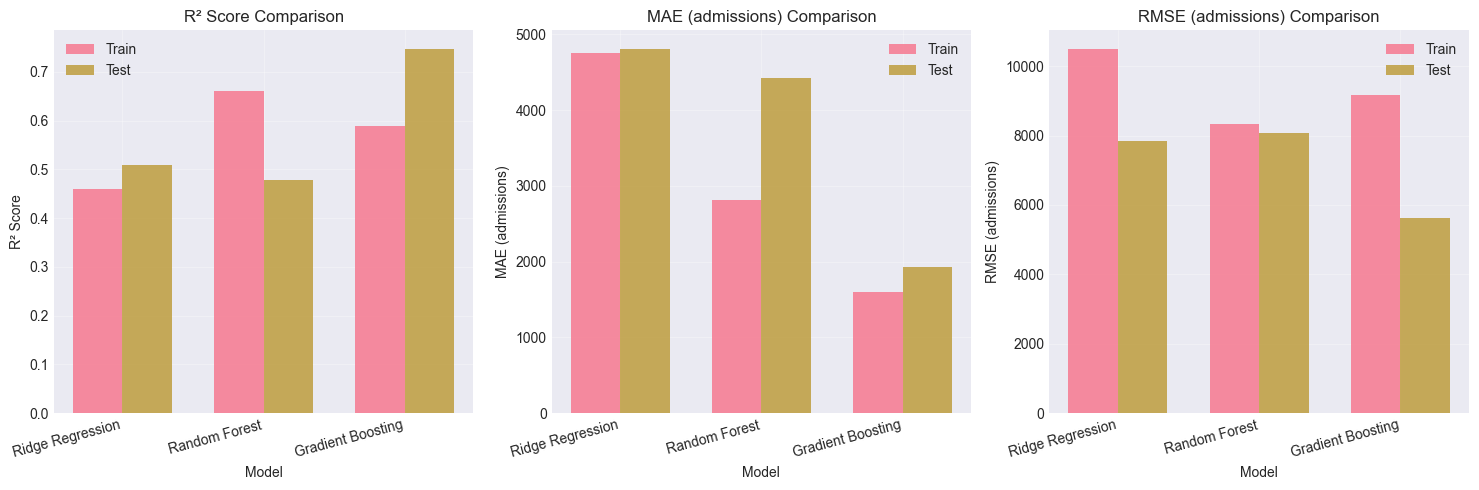

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = model_comparison["model"].values
train_metrics = [
    model_comparison["train_r2"].values,
    model_comparison["train_mae"].values,
    model_comparison["train_rmse"].values,
]
test_metrics = [
    model_comparison["test_r2"].values,
    model_comparison["test_mae"].values,
    model_comparison["test_rmse"].values,
]
metric_names = ["R² Score", "MAE (admissions)", "RMSE (admissions)"]

for idx, (train, test, name, ax) in enumerate(
    zip(train_metrics, test_metrics, metric_names, axes)
):
    x = np.arange(len(models))
    width = 0.35

    ax.bar(x - width / 2, train, width, label="Train", alpha=0.8)
    ax.bar(x + width / 2, test, width, label="Test", alpha=0.8)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"{name} Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Display State-Level Summary and Sample Predictions
Show aggregated resource needs by state and predictions for first 10 facilities (top 10)

In [27]:
display(
    demand_by_state_service[
        [
            "state",
            "service_type",
            "total_admissions",
            "predicted_admissions",
            "recommended_beds",
            "recommended_staff",
            "complexity_score",
        ]
    ].head(10)
)

display(state_summary.sort_values("predicted_admissions", ascending=False).head(10))

,state,service_type,total_admissions,predicted_admissions,recommended_beds,recommended_staff,complexity_score
0,1,1,883,853.628822,72.0,21.0,1.923216
1,1,2,2417,3903.359245,326.0,88.0,1.251924
2,1,3,7958,7913.706728,660.0,184.0,1.572242
3,1,6,1773,2011.732422,168.0,51.0,2.672138
4,1,7,1816,2092.805262,175.0,51.0,2.007654
5,2,1,1215,887.465882,74.0,23.0,2.714403
6,2,2,755,1012.107462,85.0,25.0,2.324106
7,2,3,1899,2533.092328,212.0,62.0,2.054134
8,2,6,762,854.314892,72.0,23.0,3.236220
9,2,7,285,-117.861028,-9.0,-3.0,3.637193


,state,total_admissions,predicted_admissions,recommended_beds,recommended_staff,under_resourced,complexity_score,beds_per_1000_admissions
31,36,185157,151957.053010,12668.0,3920.0,7,2.757072,68.417613
19,24,144471,98841.094311,8241.0,2484.0,8,2.555922,57.042590
29,34,81711,79472.039402,6627.0,2065.0,5,2.852883,81.102911
4,6,114547,75886.302134,6325.0,1885.0,6,2.350244,55.217509
5,8,67404,67227.934118,5608.0,1746.0,5,2.947150,83.199810
2,4,188265,66212.841205,5521.0,1592.0,5,2.084637,29.325685
21,26,66699,65202.525526,5437.0,1821.0,5,3.720722,81.515465
36,41,63919,64422.061333,5372.0,1363.0,2,0.746045,84.043868
22,27,65918,59169.446306,4933.0,1460.0,4,2.279010,74.835402
20,25,61109,57891.345824,4826.0,1653.0,4,4.466429,78.973637
